<a href="https://colab.research.google.com/github/suchig/Hotel-Reviews/blob/master/Hotel_Review_Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Download the data
!wget -O hotels.zip https://www.dropbox.com/s/owu0wbo58rcrq41/515k-hotel-reviews-data-in-europe.zip?dl=1
!unzip hotels.zip

--2019-07-21 01:05:15--  https://www.dropbox.com/s/owu0wbo58rcrq41/515k-hotel-reviews-data-in-europe.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/owu0wbo58rcrq41/515k-hotel-reviews-data-in-europe.zip [following]
--2019-07-21 01:05:20--  https://www.dropbox.com/s/dl/owu0wbo58rcrq41/515k-hotel-reviews-data-in-europe.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3229c89f8256ff47bee96056fe.dl.dropboxusercontent.com/cd/0/get/AlERrScaNTDXcik65gr_90KJT0ure2aEGiCH4MVHJiwY1aqGDncB1SUGZnzZGNAfbsTzuGamseHchv-DXfNN6-Qz5x9yY0lQoUJANT01I038BQ/file?dl=1# [following]
--2019-07-21 01:05:20--  https://uc3229c89f8256ff47bee96056fe.dl.dropboxusercontent.com/cd/0/get/AlERrScaNTDXcik65gr_90KJT0ure2aEGiCH4MVHJiwY1aqGDncB1SUGZn

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import re

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

import nltk
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

---
# Initialization of data
Read the Hotel reviews csv file and examine its structure and information


In [0]:
hotels = pd.read_csv("Hotel_Reviews.csv")
print(hotels.shape)
print(hotels.info())

(515738, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
Hotel_Address                                 515738 non-null object
Additional_Number_of_Scoring                  515738 non-null int64
Review_Date                                   515738 non-null object
Average_Score                                 515738 non-null float64
Hotel_Name                                    515738 non-null object
Reviewer_Nationality                          515738 non-null object
Negative_Review                               515738 non-null object
Review_Total_Negative_Word_Counts             515738 non-null int64
Total_Number_of_Reviews                       515738 non-null int64
Positive_Review                               515738 non-null object
Review_Total_Positive_Word_Counts             515738 non-null int64
Total_Number_of_Reviews_Reviewer_Has_Given    515738 non-null int64
Reviewer_Score                                515738

---
# Classification of reviews

This section deals with creating a classification model to train and infer positive_reviews and negative reviews . To do this structure of data has to be modified from

```
Row 1 -> Feature 1, ....Positive_Review 1, Negative Review 1,....
Row 2 -> Feature 2, ....Positive_Review 2, Negative Review 2,....
Row 3 -> Feature 3, ....Positive_Review 3, Negative Review 3,....
....
```

to the below structure
```
Row 1 -> Positive_Review 1, Rating Positive
Row 2 -> Positive_Review 2, Rating Positive
Row 3 -> Positive_Review 3, Rating Positive
Row 4 -> Negative Review 1, Rating Negative
Row 5 -> Negative Review 2, Rating Negative
Row 6 -> Negative Review 3, Rating Negative
....
```

In [0]:
neg_reviews = pd.DataFrame(hotels['Negative_Review'])
neg_reviews.rename(columns={"Negative_Review": "review"},inplace=True)
neg_reviews['rating']=0

pos_reviews = pd.DataFrame(hotels['Positive_Review'])
pos_reviews.rename(columns={"Positive_Review": "review"},inplace=True)
pos_reviews['rating']=1

reviews=pd.concat([pos_reviews,neg_reviews])

Split as test and train

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    reviews['review'], reviews['rating'], test_size=0.3, random_state=27)

In order to classify, positive and negative reviews have to be cleaned, segmented and lemmatized. After the same, CountVectorizer and TFIDTransformer will convert the reviews into tfid values.

In [0]:
lemmatizer = WordNetLemmatizer()
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

#method to split sentences to lemmatized words
def tokenize(text):
  
  # Remove punctuations
  text = text.lower().translate(remove_punct_dict)

  # Remove numeric entries
  text = re.sub("\d+", " ", text)
  
  #tokenize the sentence to words
  tokens = nltk.word_tokenize(text)
  
  #lemmatize the tokens
  tokens = [lemmatizer.lemmatize(token) for token in tokens]
  
  #remove below custom words since they are typing issues
  #remove any single letter tokens
  custom_stopWords=['wa'] 
  tokens = [t for t in tokens if ((t not in custom_stopWords) and (len(t)>1))]
  
  return tokens

In [0]:
nltk.download('punkt')
nltk.download('wordnet')
count_vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
tfid_transformer = TfidfTransformer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


X_train values are converted to Count Vector values using Count vector's fit_transform.
Count Vector values are converted to TFID values using TFI Transformer's fit_transformer.
These are fed as training X values to a classifier model, in this case, NaiveBayes Classifier (MultinomialNB)

In [0]:
count_X_train = count_vectorizer.fit_transform(X_train.values.astype(str).ravel())
tfid_X_train = tfid_transformer.fit_transform(count_X_train)
classifier = MultinomialNB()
classifier_train = classifier.fit(tfid_X_train,y_train)

Now with the trained model, y values are predicted for x and accuracy is calculated. It comes to about 88%. 

In [0]:
count_X_test = count_vectorizer.transform(X_test.values.astype(str).ravel())
tfid_X_test = tfid_transformer.transform(count_X_test)
classifier_y_pred = classifier_train.predict(tfid_X_test)
accuracy_score(y_test,classifier_y_pred)

0.9214815006317804

A confusion matrix is drawn to see the accuracy

In [0]:
def plot_confusion_matrix(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)

    classes = ['0','1']

    plt.imshow(cm);
    plt.xticks([0,1],classes)
    plt.yticks(np.arange(cm.shape[0]),classes)

    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.text(0,0, cm[0,0],ha="center", va="center")
    plt.text(0,1, cm[1,0],ha="center", va="center",color="white")
    plt.text(1,0, cm[0,1],ha="center", va="center",color="white")
    plt.text(1,1, cm[1,1],ha="center", va="center");
    plt.show()

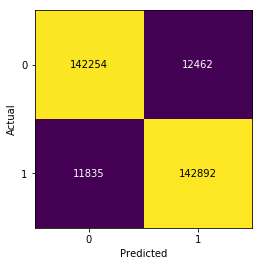

In [0]:
plot_confusion_matrix(y_test,classifier_y_pred)

theThe same is repeated with SGDClassifier to see if it can have better prediction. As seen below, the performance is similar to that of MultinomialNB

In [0]:
svm = SGDClassifier()
svm_train = svm.fit(tfid_X_train,y_train)
svm_y_pred = svm_train.predict(tfid_X_test)
accuracy_score(y_test,svm_y_pred)

0.9235594277459823

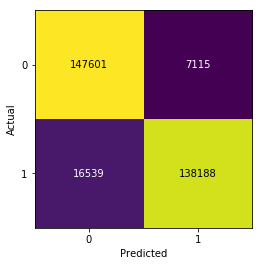

In [0]:
plot_confusion_matrix(y_test,svm_y_pred)



---

# Frequent words
This section addresses Top positive and Negative words. There are two ways to address this
1. Take Positive and Negative words together and identify the TFID values. This is similar to what was done above. However this has to be done for the whole reviews set instead of Train or Test
2. Identify TFID for Positive words separately and Negative words separately. This means Count Vectorization and TFID Transofrmer will be run separately on Positive and Negative reviews

A common method to pull the most frequent words from TFID is useful.

In [0]:
def get_most_freq(X,vector,n):
  avg_features = X.mean(axis=0)
  words_list = ((word, avg_features[0, i], i) for word, i in vector.vocabulary_.items())

  return sorted(words_list, key = lambda x: x[1], reverse=True)[:n]

**Method 1: Take total reviews to find the Top Positive and Negative words**

As first step, TFID values are derived for the entire review set

In [0]:
count_total = count_vectorizer.fit_transform(reviews['review'])
tfid_total = tfid_transformer.fit_transform(count_total)

Before proceeding to top frequency positive and negative words, it will be interesting to look at Top 100 words as a Word Cloud

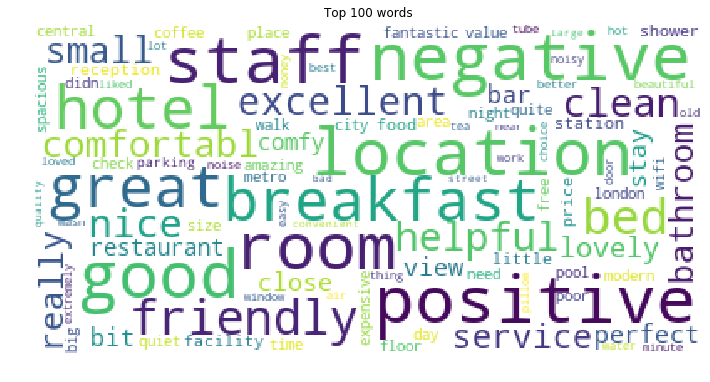

In [0]:
top_freq_words = get_most_freq(tfid_total,count_vectorizer,100)
ar_top_freq_words = np.array(top_freq_words,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])

wordcloud = WordCloud(
                          background_color='white',
                          max_words=1000,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(ar_top_freq_words['w']).replace('\'',''))

fig = plt.figure(1,figsize=(12,12))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Top 100 words")
plt.show()

A function is defined to plot Top Positive and Negative words from TFID

In [0]:
def plot_top_pos_neg_words(tfid_pos,tfid_neg,count):
  pos_freq_words = get_most_freq(tfid_pos,count_vectorizer,count)
  neg_freq_words = get_most_freq(tfid_neg,count_vectorizer,count)

  print(pos_freq_words)
  print(neg_freq_words)
  
  fig=plt.figure(figsize=(16,8))
  ax=fig.add_subplot(1,2,1)
  ar_pos_freq_words = np.array(pos_freq_words,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])
  pos_width = ar_pos_freq_words['c']
  pos_words = ar_pos_freq_words['w']
  ax.barh(np.arange(count),pos_width,color='green');
  ax.set_yticks(np.arange(count))
  ax.set_yticklabels(pos_words)
  ax.set_title("Top Positive Words")
  ax=fig.add_subplot(1,2,2)
  ar_neg_freq_words = np.array(neg_freq_words,dtype=[('w', '<U10'), ('c', 'float64'),('i', '<i4')])
  neg_width = ar_neg_freq_words['c']
  neg_words = ar_neg_freq_words['w']
  ax.barh(np.arange(count),neg_width,color='red');
  ax.set_yticks(np.arange(count))
  ax.set_yticklabels(neg_words);
  ax.set_title("Top Negative Words")
  plt.show();

Since total reviews was a concatenation of Positive Reviews and Negative Reviews, top values of total 
TFID will pertain to Positive Reviews. Based on this information, TFID values can be split into TFID_Pos 
and TFID_Neg and the plot can be made to find Top 15 words

[('location', 0.10720126526982558, 36920), ('staff', 0.07476666483342202, 59486), ('positive', 0.06997433823699925, 48027), ('good', 0.05243113255433858, 27736), ('room', 0.04973016163695023, 53750), ('great', 0.04949756863865246, 28119), ('friendly', 0.04317571684100007, 26098), ('hotel', 0.03884768752871838, 30535), ('breakfast', 0.03746250854626602, 8225), ('helpful', 0.03649774633917549, 29638), ('excellent', 0.034437720352702095, 22697), ('clean', 0.034329928162590666, 11932), ('nice', 0.033601253211339485, 42445), ('comfortable', 0.030990896953666476, 12935), ('bed', 0.030831398186334662, 6264)]
[('negative', 0.2489757162457015, 42044), ('room', 0.04646418299378408, 53750), ('small', 0.02723457326258464, 57757), ('breakfast', 0.020731417743306387, 8225), ('hotel', 0.01716479960400309, 30535), ('bit', 0.014468500585425639, 7131), ('bed', 0.012372754277463576, 6264), ('little', 0.011735959967606435, 36658), ('expensive', 0.011437781221129867, 23163), ('bathroom', 0.0113029814871612

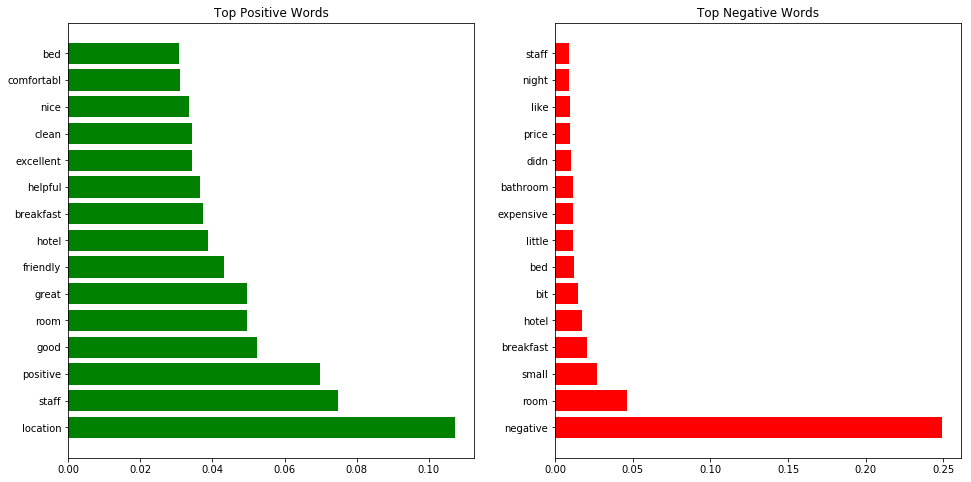

In [0]:
tfid_pos = tfid_total[0:pos_reviews.shape[0]]
tfid_neg = tfid_total[pos_reviews.shape[0]:]

plot_top_pos_neg_words(tfid_pos,tfid_neg,15)

**Method 2: Consider Positive Reviews and Negative Reviews separately**

In order to this TFID values are retrieved for both Positive Reviews and Negative Reviews in hotels dataframe, but separately

In [0]:
count_neg = count_vectorizer.fit_transform(hotels['Negative_Review'])
tfid_neg = tfid_transformer.fit_transform(count_neg)

count_pos = count_vectorizer.fit_transform(hotels['Positive_Review'])
tfid_pos = tfid_transformer.fit_transform(count_pos)

[('location', 0.09557816590911236, 23804), ('positive', 0.06994401955910716, 31044), ('staff', 0.06616354484909034, 38144), ('room', 0.0521312081467436, 34586), ('good', 0.04848259684489779, 17890), ('great', 0.04514820734767536, 18178), ('friendly', 0.03938219712454458, 16791), ('hotel', 0.03790215972671206, 19781), ('breakfast', 0.03754259556259372, 5415), ('helpful', 0.033229020569550925, 19164), ('clean', 0.03173283318257884, 7889), ('excellent', 0.03163588563345358, 14591), ('nice', 0.030996763879667252, 27576), ('bed', 0.030375685246488468, 4139), ('comfortable', 0.028406095177209382, 8523)]
[('neiborgh', 0.24883278494430394, 27353), ('sceptic', 0.04868465206699449, 35439), ('staffh', 0.025015441482751623, 38162), ('boufet', 0.022799255091495545, 5215), ('hyge', 0.019181686805528318, 20078), ('bathrroms', 0.014048030652092409, 3915), ('beshoy', 0.013186478573087981, 4458), ('suprises', 0.01243113771868757, 39367), ('barcelonna', 0.011315172936861382, 3708), ('lourds', 0.011042918

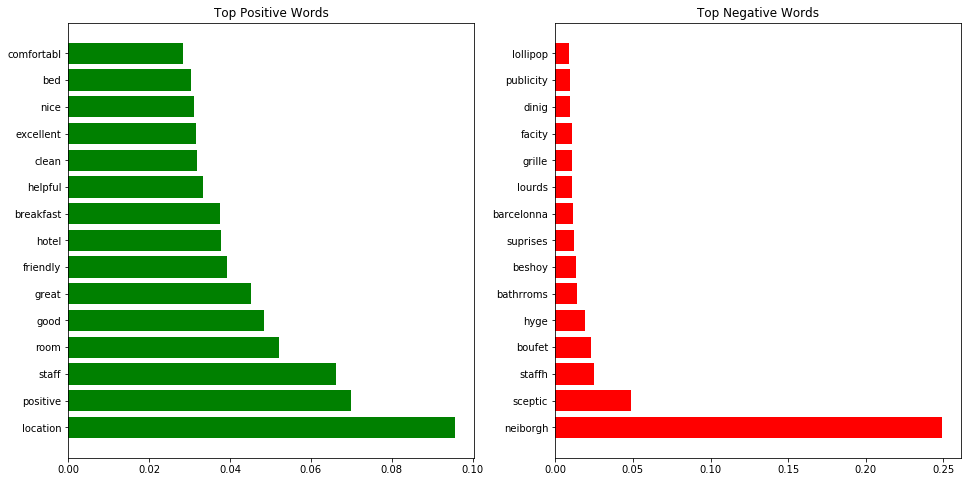

In [0]:
plot_top_pos_neg_words(tfid_pos,tfid_neg,15)